In [1]:
# import lightning as L
# from torch.utils.data import random_split, DataLoader, Dataset
# import h5py
# import numpy as np
# from scipy.fft import fft, fftfreq
# import torch
# from noise import *
# #from utils import fft_func_complex

# def fft_func_IQ_abs(signal_I, signal_Q):
#     signal = signal_I + 1j*signal_Q
#     N = len(signal)
#     yf = fft(signal)
#     return np.abs(yf)

# def fft_func_IQ_complex_channels(signal_I, signal_Q):
#     signal = signal_I + 1j*signal_Q
#     N = len(signal)
#     yf = fft(signal)
#     real_part = yf.real
#     imag_part = yf.imag
#     return real_part, imag_part

# class Project8Sim(Dataset):
#     def __init__(self, inputs, variables, observables, path='/gpfs/gibbs/pi/heeger/hb637/ssm_files_pi_heeger/combined_data_fullsim.hdf5', cutoff=4000, norm=True, noise_const=1,
#             apply_filter = False, apply_fft=False, complex_channels=False, ts_and_fft):
#         arr = {}
#         with h5py.File(path, 'r') as f:
#             for i in inputs+variables+observables:
#                 #arr[i] = f[i][:100]
#                 arr[i] = f[i][:]
#                 arr[i] = arr[i][:, np.newaxis]
#         X = np.concatenate([arr[i] for i in inputs], axis = 1)
#         X = np.swapaxes(X,1,2)[:,:cutoff, :]
#         y = np.concatenate([arr[v] for v in variables], axis = 1)
#         obs = np.concatenate([arr[o] for o in observables], axis = 1)
#         # add noise and normalize by std

#         if ('output_ts_I' in inputs) and ('output_ts_Q' in inputs) and apply_fft:
#             index_ts_I = inputs.index('output_ts_I')
#             index_ts_Q = inputs.index('output_ts_Q')
#             for i in range(X.shape[0]):
#                 for j in range(X.shape[2]):
#                     noise_arr = noise_model(cutoff, noise_const)
#                     X_noise = X[i, :, j] + noise_arr
#                     if(apply_filter): # whether to apply the band pass filter
#                         X_noise = bandpass_filter(X_noise)
#                     if(norm): # whether to normalize by std
#                         std_X = np.std(X_noise)
#                     else:
#                         std_X = 1
#                     X[i, :, j] = X_noise/std_X

#                 if(complex_channels):
#                     X[i,:,index_ts_I], X[i,:,index_ts_Q] = fft_func_IQ_complex_channels(X[i, :, index_ts_I], X[i, :, index_ts_Q])
#                 else:
#                     X[i,:,0] = fft_func_IQ_abs(X[i, :, index_ts_I], X[i, :, index_ts_Q])


#             if apply_fft and not(complex_channels):
#                 X = X[:,:,0]
#                 X = X[:, :, np.newaxis]
        
#         else:
#             for i in range(X.shape[0]):
#                 for j in range(X.shape[2]):
#                     noise_arr = noise_model(cutoff, noise_const)
#                     X_noise = X[i, :, j] + noise_arr
#                     if(apply_filter): # whether to apply the band pass filter
#                         X_noise = bandpass_filter(X_noise)
#                     if(apply_fft):
#                         X_noise = fft_func(X_noise)
#                         if len(X_noise) < cutoff:
#                             X_noise = np.pad(X_noise, (0, cutoff - len(X_noise)), mode='constant')
#                     if(norm and not(apply_fft)): # whether to normalize by std
#                         std_X = np.std(X_noise)
#                     else:
#                         std_X = 1
#                     X[i, :, j] = X_noise/std_X

#         if norm:
#             mu_y = np.mean(y, axis=0)
#             stds_y = np.std(y, axis=0)
#             y = (y-mu_y)/stds_y
            
#         self.mu = mu_y
#         self.stds = stds_y
#         self.timeseries = np.float32(X)
#         self.vars = np.float32(y)
#         self.obs = np.float32(obs)
        
#     def __len__(self):
#         return self.vars.shape[0]
    
#     def __getitem__(self, idx):
#         times = self.timeseries[idx, :, :]
#         var = self.vars[idx]
#         obs = self.obs[idx, :]
#         return times, var, obs
    
#     def __outdim__(self):
#         return self.vars.shape[1]
    
#     def __indim__(self):
#         return self.timeseries.shape[1]

In [1]:
import lightning as L
from torch.utils.data import random_split, DataLoader, Dataset
import h5py
import numpy as np
from scipy.fft import fft, fftfreq
import torch
from noise import *
#from utils import fft_func_complex

def fft_func_IQ_abs(signal_I, signal_Q):
    signal = signal_I + 1j*signal_Q
    N = len(signal)
    yf = fft(signal)
    return np.abs(yf)

def fft_func_IQ_complex_channels(signal_I, signal_Q):
    signal = signal_I + 1j*signal_Q
    N = len(signal)
    yf = fft(signal)
    real_part = yf.real
    imag_part = yf.imag
    return real_part, imag_part

class Project8Sim(Dataset):
    def __init__(self, inputs, variables, observables, path='/gpfs/gibbs/pi/heeger/hb637/ssm_files_pi_heeger/combined_data_fullsim.hdf5', cutoff=4000, norm=True, noise_const=1,
            apply_filter = False, apply_fft=False, complex_channels=False, ts_and_fft=False):
        arr = {}
        with h5py.File(path, 'r') as f:
            for i in inputs+variables+observables:
                #arr[i] = f[i][:100]
                arr[i] = f[i][:]
                arr[i] = arr[i][:, np.newaxis]
        X = np.concatenate([arr[i] for i in inputs], axis = 1)
        X = np.swapaxes(X,1,2)[:,:cutoff, :]
        y = np.concatenate([arr[v] for v in variables], axis = 1)
        obs = np.concatenate([arr[o] for o in observables], axis = 1)
        # add noise and normalize by std

        X_ts = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[2]):
                noise_arr = noise_model(cutoff, noise_const)
                X_noise = X[i, :, j] + noise_arr
                if apply_filter:
                    X_noise = bandpass_filter(X_noise)
                if norm:
                    std_X = np.std(X_noise)
                else:
                    std_X = 1
                X_ts[i, :, j] = X_noise / std_X

        X_fft = None
        if apply_fft or ts_and_fft:
            if ('output_ts_I' in inputs) and ('output_ts_Q' in inputs):
                index_ts_I = inputs.index('output_ts_I')
                index_ts_Q = inputs.index('output_ts_Q')
                X_fft = np.zeros_like(X_ts)

                for i in range(X.shape[0]):
                    if complex_channels:
                        real_part, imag_part = fft_func_IQ_complex_channels(
                            X_ts[i, :, index_ts_I],
                            X_ts[i, :, index_ts_Q]
                        )
                        X_fft[i, :, index_ts_I] = real_part
                        X_fft[i, :, index_ts_Q] = imag_part
                    else:
                        abs_fft = fft_func_IQ_abs(
                            X_ts[i, :, index_ts_I],
                            X_ts[i, :, index_ts_Q]
                        )
                        X_fft[i, :, 0] = abs_fft
                if not complex_channels:
                    X_fft = X_fft[:, :, [0]]

        if ts_and_fft:
            X = np.concatenate([X_ts, X_fft], axis=2)
        elif apply_fft:
            X = X_fft
        else:
            X = X_ts

        if norm:
            mu_y = np.mean(y, axis=0)
            stds_y = np.std(y, axis=0)
            y = (y - mu_y) / stds_y

        self.mu = mu_y
        self.stds = stds_y
        self.timeseries = np.float32(X)
        self.vars = np.float32(y)
        self.obs = np.float32(obs)

    def __len__(self):
        return self.vars.shape[0]

    def __getitem__(self, idx):
        times = self.timeseries[idx, :, :]
        var = self.vars[idx]
        obs = self.obs[idx, :]
        return times, var, obs

    def __outdim__(self):
        return self.vars.shape[1]

    def __indim__(self):
        return self.timeseries.shape[1]

In [12]:
inputs = ['output_ts_I', "output_ts_Q"]
variables = ['energy_eV', 'pitch_angle_deg']
observables = ['avg_axial_frequency_Hz', 'avg_carrier_frequency_Hz', 'radius_m']

data = Project8Sim(inputs, variables, observables, path='/gpfs/gibbs/pi/heeger/hb637/ssm_files_pi_heeger/combined_data_fullsim.hdf5', cutoff=4000, norm=True, noise_const=0,
            apply_filter = False, apply_fft=False, complex_channels=False, ts_and_fft=False)

In [13]:
data.timeseries[18900][:,0]

array([ 0.02802243,  1.0368297 ,  1.4851886 , ...,  0.47638124,
        0.14011213, -0.19615698], dtype=float32)

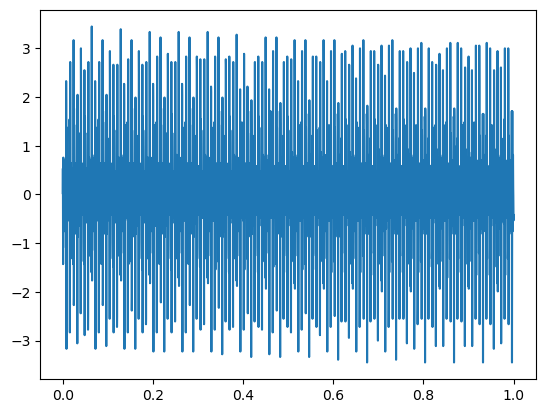

In [16]:
import matplotlib.pyplot as plt

amplitudes = data.timeseries[18900][:,1]
times = np.linspace(0,1,4000)

plt.plot(times, amplitudes)